# Step 4: Test Recommender Simulation

**Simulate Real-World Out-of-Stock Scenario**

## 🎯 Objective
Validate the Fashion Recommender system by simulating what happens when a customer finds a product they like, but it's **OUT OF STOCK**. The system should instantly recommend 5 similar available alternatives.

## 📋 Workflow

```
CUSTOMER JOURNEY:
1. Browse store → Finds Product X (Love it!)
2. Product X is OUT OF STOCK ❌
3. System: "We have 5 similar items available!" 
4. Show 5 recommendations with images & similarity scores
5. Customer clicks alternative → KEEPS SHOPPING ✅

THIS NOTEBOOK SIMULATES STEPS 1-5
```

## ✅ What We'll Test
- ✓ Load pre-built FAISS index and embeddings
- ✓ Select a product (user-chosen or random)
- ✓ Mark it as out-of-stock
- ✓ Get 5 similar in-stock recommendations
- ✓ Visualize results (side-by-side comparison)
- ✓ Run batch tests across multiple scenarios

In [1]:
# Section 1: Load Pre-Built FAISS Index and Embeddings
import sys
from pathlib import Path

# Add src to path to import our recommender module
root_dir = Path.cwd().parent
sys.path.insert(0, str(root_dir))

# Import recommender directly
import importlib.util
spec = importlib.util.spec_from_file_location("recommender", root_dir / "src" / "recommender.py")
recommender_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(recommender_module)
FashionRecommender = recommender_module.FashionRecommender

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

print("=" * 70)
print("LOADING PRE-BUILT ARTIFACTS")
print("=" * 70)

# Initialize recommender
recommender = FashionRecommender(index_dir=str(root_dir / "Index"), verbose=True)

print("\n✓ Recommender initialized successfully!")

# Get system stats
stats = recommender.get_stats()
print("\n" + "=" * 70)
print("SYSTEM STATISTICS")
print("=" * 70)
print(f"Total products: {stats['num_products']}")
print(f"Embedding dimension: {stats['embedding_dim']}")
print(f"Categories: {', '.join(stats['categories'])}")
print(f"In-stock items: {stats['in_stock_count']}")
print(f"Out-of-stock items: {stats['out_of_stock_count']}")

INFO:recommender:✓ Loaded FAISS index: 52712 vectors


LOADING PRE-BUILT ARTIFACTS


INFO:recommender:✓ Loaded embeddings: (52712, 1024)
INFO:recommender:✓ Loaded valid indices: 52712 products
INFO:recommender:✓ Loaded products: 52712 rows
INFO:recommender:✓ Added is_in_stock column (all products marked as in stock)
INFO:recommender:✓ Built product_id → embedding index map (52712 entries)



✓ Recommender initialized successfully!

SYSTEM STATISTICS
Total products: 52712
Embedding dimension: 1024
Categories: Blouse, Cardigan, Denim, Dress, Graphic_Tees, Jacket, Jackets_Vests, Leggings, Pants, Rompers_Jumpsuits, Shirts_Polos, Shorts, Skirt, Suiting, Sweater, Sweatshirts_Hoodies, Tee
In-stock items: 52712
Out-of-stock items: 0


## Section 2: Create Interactive Product Selector

Browse and select products to simulate as out-of-stock.

In [2]:
# Product Selection Functions
from random import randint

def get_products_by_category(category_name):
    """Get all product IDs for a specific category."""
    return recommender.products[recommender.products['category'] == category_name]['product_id'].tolist()

def select_product(product_id=None, category=None):
    """
    Select a product to test.
    
    Args:
        product_id (int): Specific product ID to select
        category (str): Select random product from category
    
    Returns:
        dict: Product information
    """
    if product_id is not None:
        try:
            info = recommender.get_product_info(product_id)
            return product_id, info
        except ValueError:
            print(f"❌ Product ID {product_id} not found!")
            return None, None
    
    elif category is not None:
        products = get_products_by_category(category)
        if not products:
            print(f"❌ No products found in category: {category}")
            return None, None
        pid = products[randint(0, len(products)-1)]
        info = recommender.get_product_info(pid)
        return pid, info
    
    else:
        # Random product
        pid = randint(1, recommender.get_stats()['num_products'])
        try:
            info = recommender.get_product_info(pid)
            return pid, info
        except:
            return select_product()  # Try again

# Display available categories
print("\n" + "=" * 70)
print("AVAILABLE CATEGORIES")
print("=" * 70)
categories = recommender.get_stats()['categories']
for i, cat in enumerate(categories, 1):
    count = len(get_products_by_category(cat))
    print(f"{i:2}. {cat:20} ({count:4} products)")

# Example: Select a random dress
print("\n" + "=" * 70)
print("SELECTING EXAMPLE PRODUCT")
print("=" * 70)
example_pid, example_info = select_product(category="Dress")
print(f"\n✓ Selected Product ID: {example_pid}")
print(f"  Category: {example_info['category']}")
print(f"  Image: {example_info['image_path']}")
print(f"  Status: In Stock")


AVAILABLE CATEGORIES
 1. Blouse               (7964 products)
 2. Cardigan             (1436 products)
 3. Denim                ( 804 products)
 4. Dress                (6999 products)
 5. Graphic_Tees         (1297 products)
 6. Jacket               (1895 products)
 7. Jackets_Vests        ( 424 products)
 8. Leggings             ( 335 products)
 9. Pants                (2821 products)
10. Rompers_Jumpsuits    (1696 products)
11. Shirts_Polos         ( 722 products)
12. Shorts               (4476 products)
13. Skirt                (2045 products)
14. Suiting              (  39 products)
15. Sweater              (3641 products)
16. Sweatshirts_Hoodies  (1631 products)
17. Tee                  (14487 products)

SELECTING EXAMPLE PRODUCT

✓ Selected Product ID: 12865
  Category: Dress
  Image: img/WOMEN/Dresses/id_00002020/02_4_full.jpg
  Status: In Stock


## Section 3: Simulate Out-of-Stock Scenario

Mark selected product as unavailable and simulate customer experience.

In [3]:
# Inventory Management Simulation
class InventorySimulator:
    """Simulate inventory status for testing."""
    
    def __init__(self, products_df):
        # By default, all products are in stock
        self.inventory = {row['product_id']: 1 for _, row in products_df.iterrows()}
    
    def mark_out_of_stock(self, product_id):
        """Mark a product as out of stock."""
        if product_id in self.inventory:
            self.inventory[product_id] = 0
            return True
        return False
    
    def mark_in_stock(self, product_id):
        """Mark a product as in stock."""
        if product_id in self.inventory:
            self.inventory[product_id] = 1
            return True
        return False
    
    def get_status(self, product_id):
        """Get inventory status for product."""
        return self.inventory.get(product_id, 1)
    
    def get_in_stock_products(self):
        """Get list of all in-stock product IDs."""
        return [pid for pid, status in self.inventory.items() if status == 1]
    
    def reset(self):
        """Reset all products to in-stock."""
        for pid in self.inventory:
            self.inventory[pid] = 1

# Initialize inventory simulator
inventory = InventorySimulator(recommender.products)

print("\n" + "=" * 70)
print("SIMULATING OUT-OF-STOCK SCENARIO")
print("=" * 70)

# Mark example product as out of stock
print(f"\n🔴 Customer found: Product {example_pid} ({example_info['category']})")
print(f"   But it's OUT OF STOCK! ❌")

inventory.mark_out_of_stock(example_pid)
print(f"\n✓ Marked Product {example_pid} as out-of-stock")
print(f"  In-stock products available: {len(inventory.get_in_stock_products())}")
print(f"\n💡 System will now find similar IN-STOCK alternatives...")


SIMULATING OUT-OF-STOCK SCENARIO

🔴 Customer found: Product 12865 (Dress)
   But it's OUT OF STOCK! ❌

✓ Marked Product 12865 as out-of-stock
  In-stock products available: 52711

💡 System will now find similar IN-STOCK alternatives...


## Section 4: Query and Retrieve Recommendations

Get 5 similar in-stock alternatives using FAISS.

In [4]:
# Get recommendations with inventory filtering
print("\n" + "=" * 70)
print("QUERYING FOR RECOMMENDATIONS")
print("=" * 70)

recommendations = recommender.recommend_similar_products(
    product_id=example_pid,
    top_k=5,
    filter_category=True,
    filter_in_stock=True
)

print(f"\n✓ Found {len(recommendations)} similar IN-STOCK alternatives:\n")
print(recommendations.to_string(index=False))

# Add status column
recommendations['status'] = recommendations['product_id'].apply(
    lambda pid: '✓ IN STOCK' if inventory.get_status(pid) == 1 else '✗ OUT OF STOCK'
)

print("\n" + "=" * 70)
print("RECOMMENDATIONS WITH INVENTORY STATUS")
print("=" * 70)
print(recommendations[['product_id', 'category', 'similarity', 'status']].to_string(index=False))

if len(recommendations) == 5:
    print("\n✅ SUCCESS: Found all 5 recommendations!")
else:
    print(f"\n⚠️  WARNING: Found only {len(recommendations)} recommendations (expected 5)")

INFO:recommender:Query: Product 12865 (Dress)
INFO:recommender:FAISS search returned 25 candidates
INFO:recommender:Total candidates before filtering: 24
INFO:recommender:Candidates after filtering: 24
INFO:recommender:Returned 5 recommendations



QUERYING FOR RECOMMENDATIONS

✓ Found 5 similar IN-STOCK alternatives:

 product_id category                                        image_path  distance  similarity
      31731    Dress img/WOMEN/Dresses/id_00004808/03_7_additional.jpg  0.114204    0.897502
      19147    Dress       img/WOMEN/Dresses/id_00002976/03_4_full.jpg  0.132236    0.883208
      51192    Dress      img/WOMEN/Dresses/id_00007745/04_1_front.jpg  0.135368    0.880772
      16229    Dress img/WOMEN/Dresses/id_00002507/01_7_additional.jpg  0.136270    0.880072
      19291    Dress      img/WOMEN/Dresses/id_00003003/03_1_front.jpg  0.137227    0.879332

RECOMMENDATIONS WITH INVENTORY STATUS
 product_id category  similarity     status
      31731    Dress    0.897502 ✓ IN STOCK
      19147    Dress    0.883208 ✓ IN STOCK
      51192    Dress    0.880772 ✓ IN STOCK
      16229    Dress    0.880072 ✓ IN STOCK
      19291    Dress    0.879332 ✓ IN STOCK

✅ SUCCESS: Found all 5 recommendations!


## Section 5: Display Comparison Metrics

Visualize the out-of-stock product with its 5 recommendations side-by-side.


VISUALIZING RECOMMENDATIONS


/var/folders/m_/ptg0zwqn0b34bnnmgnqwtkvm0000gn/T/ipykernel_53952/2331624124.py:56: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/ganenthraravindran/Desktop/Fashion Recommender/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


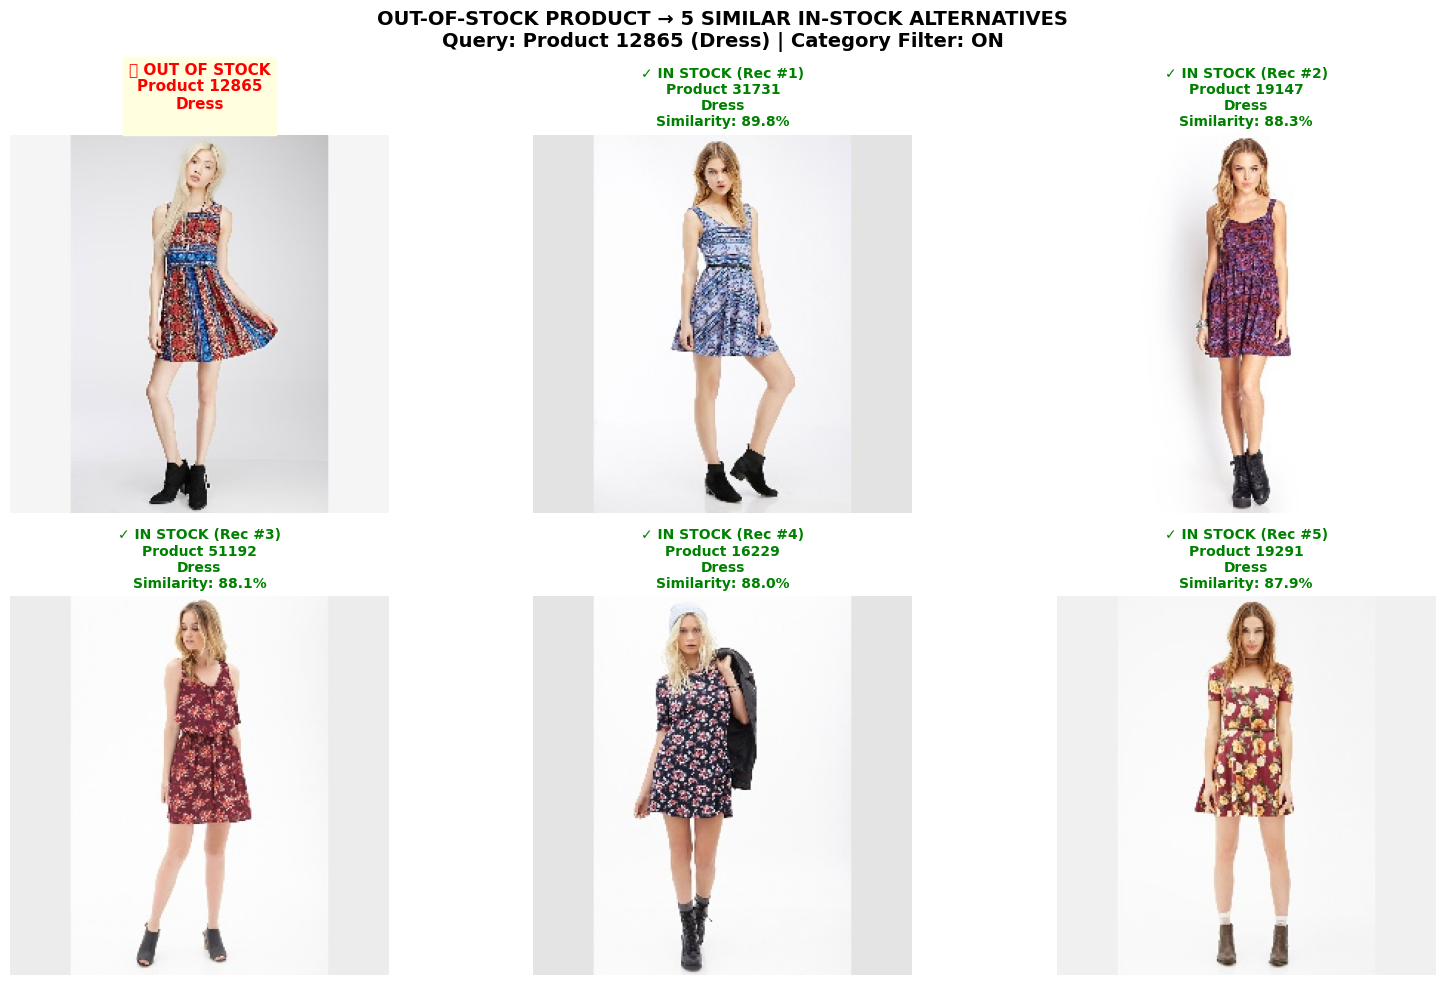


✓ Visualization complete!


In [5]:
# Visualization
data_dir = root_dir / "Data"

print("\n" + "=" * 70)
print("VISUALIZING RECOMMENDATIONS")
print("=" * 70)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle(
    f"OUT-OF-STOCK PRODUCT → 5 SIMILAR IN-STOCK ALTERNATIVES\n"
    f"Query: Product {example_pid} ({example_info['category']}) | Category Filter: ON",
    fontsize=14, fontweight='bold', y=0.98
)

# Display OUT-OF-STOCK product (marked with red border)
query_img_path = data_dir / example_info['image_path']
try:
    query_img = Image.open(query_img_path)
    axes[0, 0].imshow(query_img)
    axes[0, 0].set_title(
        f"❌ OUT OF STOCK\nProduct {example_pid}\n{example_info['category']}\n",
        fontweight='bold', fontsize=11, color='red', backgroundcolor='lightyellow'
    )
    # Add red border
    for spine in axes[0, 0].spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(3)
except Exception as e:
    axes[0, 0].text(0.5, 0.5, f"Error loading image", ha='center', va='center')

axes[0, 0].axis('off')

# Display top 5 recommendations
for idx, (ax, (_, rec_row)) in enumerate(zip(axes.flatten()[1:], recommendations.iterrows())):
    rec_img_path = data_dir / rec_row['image_path']
    try:
        rec_img = Image.open(rec_img_path)
        ax.imshow(rec_img)
        similarity_pct = rec_row['similarity'] * 100
        ax.set_title(
            f"✓ IN STOCK (Rec #{idx+1})\nProduct {int(rec_row['product_id'])}\n"
            f"{rec_row['category']}\n"
            f"Similarity: {similarity_pct:.1f}%",
            fontweight='bold', fontsize=10, color='green'
        )
        # Add green border
        for spine in ax.spines.values():
            spine.set_edgecolor('green')
            spine.set_linewidth(2)
    except Exception as e:
        ax.text(0.5, 0.5, f"Error loading image\n{rec_row['image_path']}", 
                ha='center', va='center', fontsize=8)
    
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")

## Section 6: Batch Test Multiple Scenarios

Run automated tests across different categories to validate system performance.

In [6]:
# Batch Testing Across Categories
print("\n" + "=" * 80)
print("BATCH TESTING: Multiple Out-of-Stock Scenarios")
print("=" * 80)

categories = recommender.get_stats()['categories']
test_results = []

# Test one product from each category
for category in categories:
    try:
        # Get random product from category
        product_ids = get_products_by_category(category)
        if not product_ids:
            continue
        
        test_pid = product_ids[randint(0, len(product_ids)-1)]
        
        # Get recommendations
        recs = recommender.recommend_similar_products(
            product_id=test_pid,
            top_k=5,
            filter_category=True,
            filter_in_stock=True
        )
        
        num_recs = len(recs)
        avg_similarity = recs['similarity'].mean() if len(recs) > 0 else 0
        
        test_results.append({
            'Category': category,
            'Test Product': test_pid,
            'Recommendations Found': num_recs,
            'Avg Similarity': f"{avg_similarity:.1%}",
            'Status': '✓ PASS' if num_recs == 5 else f'⚠ PARTIAL ({num_recs}/5)'
        })
        
    except Exception as e:
        test_results.append({
            'Category': category,
            'Test Product': 'ERROR',
            'Recommendations Found': 0,
            'Avg Similarity': 'N/A',
            'Status': '✗ FAIL'
        })

# Display results
results_df = pd.DataFrame(test_results)
print("\n" + results_df.to_string(index=False))

# Summary statistics
pass_count = (results_df['Status'] == '✓ PASS').sum()
total_count = len(results_df)
success_rate = (pass_count / total_count * 100) if total_count > 0 else 0

print("\n" + "=" * 80)
print("BATCH TEST SUMMARY")
print("=" * 80)
print(f"Categories tested: {total_count}")
print(f"Passed (5 recommendations): {pass_count}")
print(f"Partial/Failed: {total_count - pass_count}")
print(f"Success rate: {success_rate:.1f}%")
print(f"\n{'✅ SYSTEM VALIDATION PASSED!' if success_rate >= 80 else '⚠️  Some categories need review'}")
print("=" * 80)

INFO:recommender:Query: Product 186 (Blouse)
INFO:recommender:FAISS search returned 25 candidates
INFO:recommender:Total candidates before filtering: 24
INFO:recommender:Candidates after filtering: 4
INFO:recommender:Returned 4 recommendations
INFO:recommender:Query: Product 38044 (Cardigan)
INFO:recommender:FAISS search returned 25 candidates
INFO:recommender:Total candidates before filtering: 24
INFO:recommender:Candidates after filtering: 13
INFO:recommender:Returned 5 recommendations
INFO:recommender:Query: Product 517 (Denim)
INFO:recommender:FAISS search returned 25 candidates
INFO:recommender:Total candidates before filtering: 24
INFO:recommender:Candidates after filtering: 8
INFO:recommender:Returned 5 recommendations
INFO:recommender:Query: Product 23105 (Dress)
INFO:recommender:FAISS search returned 25 candidates
INFO:recommender:Total candidates before filtering: 24
INFO:recommender:Candidates after filtering: 20
INFO:recommender:Returned 5 recommendations
INFO:recommender:Q


BATCH TESTING: Multiple Out-of-Stock Scenarios

           Category  Test Product  Recommendations Found Avg Similarity          Status
             Blouse           186                      4          85.7% ⚠ PARTIAL (4/5)
           Cardigan         38044                      5          79.2%          ✓ PASS
              Denim           517                      5          83.9%          ✓ PASS
              Dress         23105                      5          88.9%          ✓ PASS
       Graphic_Tees         21619                      2          82.7% ⚠ PARTIAL (2/5)
             Jacket         45298                      3          78.9% ⚠ PARTIAL (3/5)
      Jackets_Vests          1117                      5          85.1%          ✓ PASS
           Leggings         13314                      5          88.6%          ✓ PASS
              Pants           962                      5          85.6%          ✓ PASS
  Rompers_Jumpsuits         15488                      5          87.9%

## Section 7: Interactive Testing - Customize Your Own Simulation

**Try different products, categories, and scenarios yourself!**

Run the cells below and modify the parameters to test different scenarios.

In [23]:
print("\n" + "=" * 70)
print("INTERACTIVE TEST #1: Pick Your Own Product")
print("=" * 70)
print("\n🎯 CUSTOMIZE THIS CELL - Try different options:\n")

# ============================================================================
# OPTION 1: Select by Specific Product ID
# ============================================================================
test_product_id = 38044     # Change this to any product ID (1-52712)

# OR OPTION 2: Select by Category (uncomment to use)
# test_category = "Jacket"  # Change to: Dress, Jacket, Tee, Pants, etc.
# test_product_ids = get_products_by_category(test_category)
# test_product_id = test_product_ids[randint(0, len(test_product_ids)-1)]

# OR OPTION 3: Random product (uncomment to use)
# test_product_id = randint(1, recommender.get_stats()['num_products'])

# ============================================================================

print(f"Selected: Product ID {test_product_id}\n")

try:
    test_info = recommender.get_product_info(test_product_id)
    print(f"✓ Product found!")
    print(f"  Category: {test_info['category']}")
    print(f"  Image: {test_info['image_path']}")
    
    # Get recommendations
    print(f"\n📊 Finding similar items in {test_info['category']} category...")
    test_recs = recommender.recommend_similar_products(
        product_id=test_product_id,
        top_k=5,
        filter_category=True,
        filter_in_stock=True
    )
    
    print(f"\n✅ Found {len(test_recs)} recommendations:\n")
    print(test_recs[['product_id', 'category', 'similarity']].to_string(index=False))
    
except Exception as e:
    print(f"❌ Error: {e}")

INFO:recommender:Query: Product 38044 (Cardigan)
INFO:recommender:FAISS search returned 25 candidates
INFO:recommender:Total candidates before filtering: 24
INFO:recommender:Candidates after filtering: 13
INFO:recommender:Returned 5 recommendations
INFO:recommender:FAISS search returned 25 candidates
INFO:recommender:Total candidates before filtering: 24
INFO:recommender:Candidates after filtering: 13
INFO:recommender:Returned 5 recommendations



INTERACTIVE TEST #1: Pick Your Own Product

🎯 CUSTOMIZE THIS CELL - Try different options:

Selected: Product ID 38044

✓ Product found!
  Category: Cardigan
  Image: img/WOMEN/Cardigans/id_00005760/02_7_additional.jpg

📊 Finding similar items in Cardigan category...

✅ Found 5 recommendations:

 product_id category  similarity
      38042 Cardigan    0.796170
      38043 Cardigan    0.795549
      38041 Cardigan    0.790700
      23305 Cardigan    0.789061
      14764 Cardigan    0.788754



INTERACTIVE TEST #2: Visualize Your Test


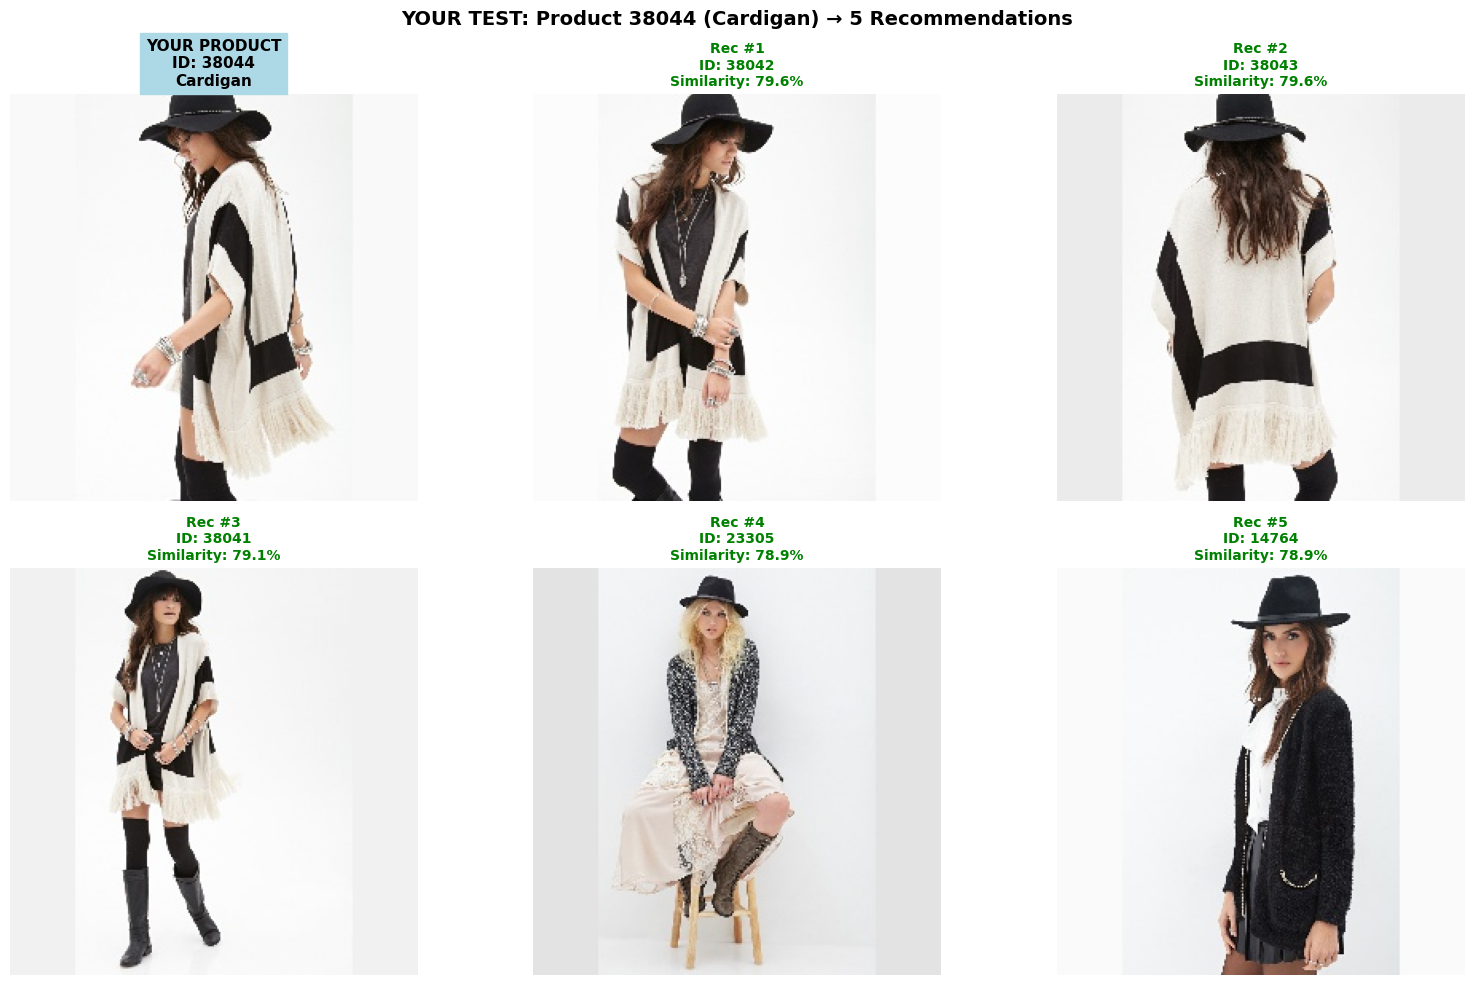

✓ Visualization complete!


In [24]:
print("\n" + "=" * 70)
print("INTERACTIVE TEST #2: Visualize Your Test")
print("=" * 70)

try:
    # Create visualization for test product
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    fig.suptitle(
        f"YOUR TEST: Product {test_product_id} ({test_info['category']}) → 5 Recommendations",
        fontsize=14, fontweight='bold', y=0.98
    )
    
    # Query image
    query_img_path = data_dir / test_info['image_path']
    try:
        query_img = Image.open(query_img_path)
        axes[0, 0].imshow(query_img)
        axes[0, 0].set_title(f"YOUR PRODUCT\nID: {test_product_id}\n{test_info['category']}", 
                             fontweight='bold', fontsize=11, backgroundcolor='lightblue')
        for spine in axes[0, 0].spines.values():
            spine.set_edgecolor('blue')
            spine.set_linewidth(2)
    except:
        axes[0, 0].text(0.5, 0.5, "Image not found", ha='center', va='center')
    axes[0, 0].axis('off')
    
    # Recommendations
    for idx, (ax, (_, rec_row)) in enumerate(zip(axes.flatten()[1:], test_recs.iterrows())):
        rec_img_path = data_dir / rec_row['image_path']
        try:
            rec_img = Image.open(rec_img_path)
            ax.imshow(rec_img)
            similarity_pct = rec_row['similarity'] * 100
            ax.set_title(f"Rec #{idx+1}\nID: {int(rec_row['product_id'])}\n"
                        f"Similarity: {similarity_pct:.1f}%",
                        fontweight='bold', fontsize=10, color='green')
            for spine in ax.spines.values():
                spine.set_edgecolor('green')
                spine.set_linewidth(2)
        except:
            ax.text(0.5, 0.5, f"Image error", ha='center', va='center', fontsize=8)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    print("✓ Visualization complete!")
    
except Exception as e:
    print(f"❌ Visualization error: {e}")